<a href="https://colab.research.google.com/github/nicolazilio0/deepRiccy/blob/main/Save_stable_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

! tar -zxf /content/drive/MyDrive/refcocog.tar.gz
! pip3 install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt 
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

local_path = '/content/refcocog/images/'
local_annotations = '/content/refcocog/annotations/'

Mounted at /content/drive
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 184.3/184.3 kB 10.1 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 592.7/592.7 kB 49.9 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 62.7/62.7 kB 9.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 53.1/53.1 kB 4.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-efxefqvi
  Running command git clone --filter=blob:none --quiet https://git

In [ ]:
#imports

import json
import pickle
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from pkg_resources import packaging
import clip
import numpy as np

import os
import skimage
import IPython.display

from collections import OrderedDict
import torch

In [ ]:
#dataset class definition
class Coco(Dataset):
    def __init__(self, path_json, path_pickle, train=True):
        self.path_json = path_json
        self.path_pickle = path_pickle
        self.train = train

        #load images and annotations
        with open(self.path_json) as json_data:
            data = json.load(json_data)
            self.ann_frame = pd.DataFrame(data['annotations'])
            self.ann_frame = self.ann_frame.reset_index(drop=False)

        with open(self.path_pickle, 'rb') as pickle_data:
            data = pickle.load(pickle_data)
            self.refs_frame = pd.DataFrame(data)

        #separate each sentence in dataframe
        self.refs_frame = self.refs_frame.explode('sentences')
        self.refs_frame = self.refs_frame.reset_index(drop=False)

        self.size = self.refs_frame.shape[0]

        #merge the dataframes
        self.dataset = pd.merge(self.refs_frame, self.ann_frame, left_on='ann_id', right_on='id')
        #drop useless columns for cleaner and smaller dataset
        self.dataset = self.dataset.drop(columns=['segmentation',  'iscrowd', 'image_id_y', 'image_id_x', 'sent_ids', 'index_y', 'area'])
        #self.dataset = self.dataset.drop(columns=['segmentation', 'id', 'category_id_y','ref_id', 'index_x', 'iscrowd', 'image_id_y', 'image_id_x', 'category_id_x', 'ann_id', 'sent_ids', 'index_y', 'area'])

    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        return self.dataset.iloc[idx]

    def get_annotation(self, idx):
      return self.ann_frame.iloc[idx]
    
    def get_imgframe(self, idx):
      return self.img_frame.iloc[idx]

    def get_validation(self):
        return self.dataset[self.dataset['split'] == 'val']
    
    def get_test(self):
        return self.dataset[self.dataset['split'] == 'test']
    
    def get_train(self):
        return self.dataset[self.dataset['split'] == 'train']



In [ ]:
def split_string(string):
    string = string.split("_")
    string = string[:-1]
    string = "_".join(string)
    append = ".jpg"
    string = string + append
    
    return string

In [ ]:
dataset = Coco(local_annotations + 'instances.json', local_annotations + "refs(umd).p")


rm: cannot remove 'bb*': No such file or directory


/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 üöÄ 2023-5-29 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 166M/166M [00:03<00:00, 51.8MB/s]

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients
Adding AutoSh

cow
145.0 81.0 384.0 259.0


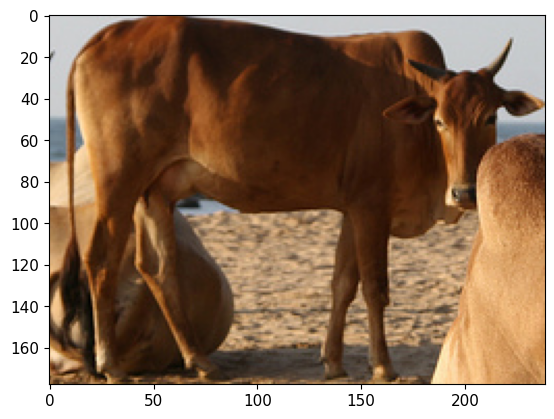

the closest cow
person
403.0 50.0 455.0 170.0


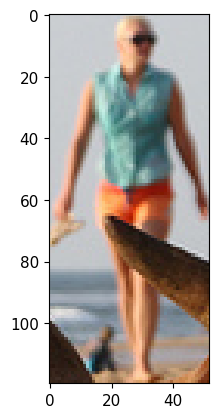

the closest cow
person
468.0 52.0 519.0 138.0


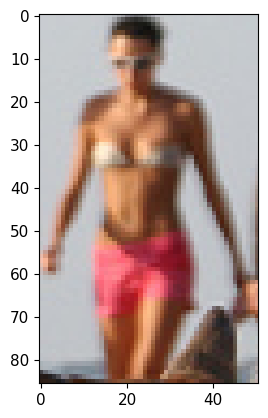

the closest cow
person
13.0 143.0 40.0 185.0


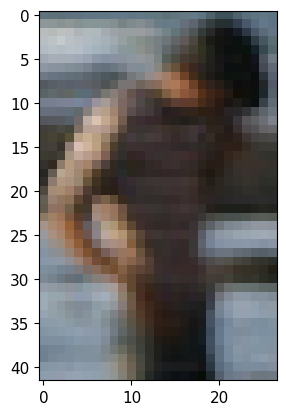

the closest cow
cow
323.0 115.0 582.0 369.0


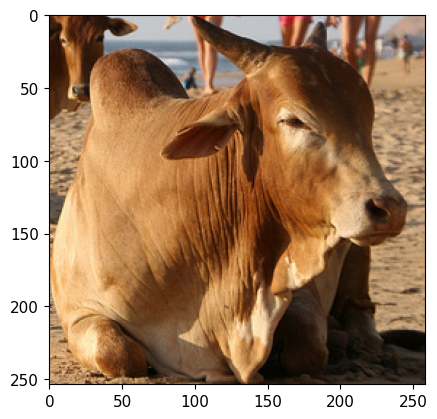

the closest cow
person
516.0 40.0 566.0 167.0


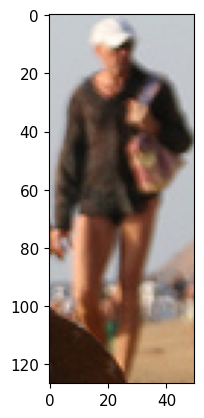

the closest cow
cow
49.0 94.0 156.0 219.0


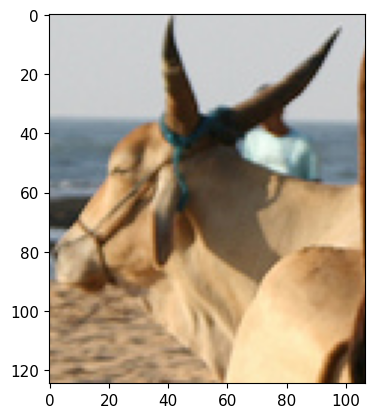

the closest cow
cow
80.0 171.0 234.0 257.0


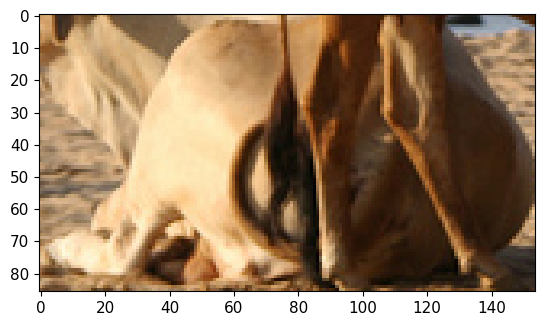

the closest cow
person
622.0 86.0 640.0 167.0


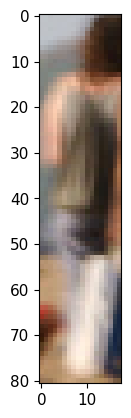

the closest cow
person
113.0 123.0 140.0 150.0


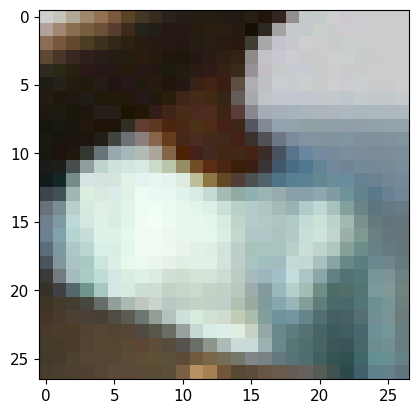

the closest cow
person
564.0 128.0 574.0 157.0


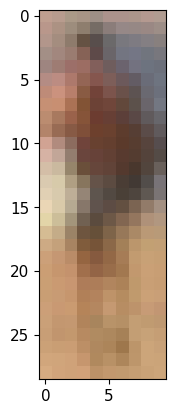

the closest cow
person
579.0 132.0 589.0 160.0


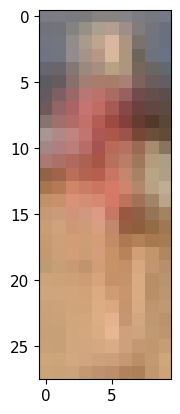

the closest cow
person
590.0 127.0 604.0 160.0


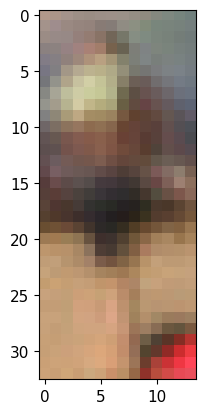

the closest cow
handbag
540.0 71.0 565.0 103.0


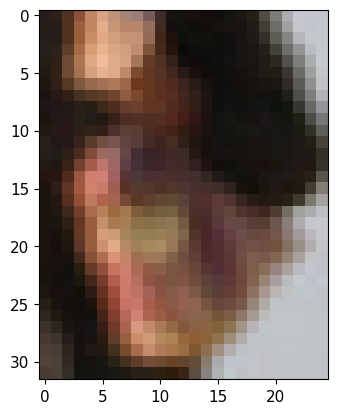

the closest cow


In [ ]:
! rm bb*
#define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#pass image into yolo
yolo = torch.hub.load('ultralytics/yolov5', 'yolov5x', pretrained=True)

#input = dataset[55]
input = dataset[55]

image = split_string(input["file_name"])

yolo_output = yolo(local_path+image)

class_names=yolo.names
model, preprocess = clip.load("ViT-B/32")
model.eval()

#pass each bounding box segmented image into clip with the sentence
for i in range(len(yolo_output.xyxy[0])):



    # convert the tensor to a numpy array
    #numpy_array = cpu_tensor.numpy()
    #x1 = yolo_output.xyxy[0][i][0].numpy()
    class_index=int(yolo_output.pred[0][i][5])
    label=class_names[class_index]
    print(label)
    x1 = yolo_output.xyxy[0][i][0].cpu().numpy()
    x1 = np.rint(x1)

    y1 = yolo_output.xyxy[0][i][1].cpu().numpy()
    y1 = np.rint(y1)
    x2 = yolo_output.xyxy[0][i][2].cpu().numpy()
    x2 = np.rint(x2)
    y2 = yolo_output.xyxy[0][i][3].cpu().numpy()
    y2 = np.rint(y2)

    print(x1, y1, x2, y2)

    img = Image.open(local_path+image).convert("RGB")    
    img = img.crop((x1, y1, x2, y2))
    if(i<10):
      img.save("bb_0"+str(i)+".jpg")
    else:
      img.save("bb_"+str(i)+".jpg")

    %matplotlib inline
    plt.imshow(img)
    plt.show()
    img = preprocess(img).unsqueeze(0)
    image_imput = torch.tensor(img)
    sentence = input["sentences"]["raw"]
    print(sentence)
    text = clip.tokenize([sentence])
    
    ''' with torch.no_grad():
        image_features = model.encode_image(img).float()
        text_features = model.encode_text(text).float()
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
    print(similarity)'''


In [ ]:
! pip install ftfy regex tqdm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

In [ ]:
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 524.9/524.9 kB 23.1 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 224.5/224.5 kB 29.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7.1/7.1 MB 87.4 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 219.1/219.1 kB 31.1 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7.8/7.8 MB 94.8 MB/s eta 0:00:00


In [ ]:
import torch
from diffusers import StableDiffusionPipeline
#pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1", torch_dtype=torch.float16)  
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16) 

Fetching 20 files:   0%|          | 0/20 [00:00<?, ?it/s]

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [ ]:
from diffusers import DPMSolverMultistepScheduler
pipe = pipe.to("cuda")


In [ ]:
dataset=dataset.get_test()


‚ï≠‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ Traceback (most recent call last) ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïÆ
‚îÇ in <cell line: 1>:1                                                                              ‚îÇ
‚îÇ                                                                                                  ‚îÇ
‚îÇ /usr/local/lib/python3.10/dist-packages/pandas/core/generic.py:5902 in __getattr__               ‚îÇ
‚îÇ                                                                                                  ‚îÇ
‚îÇ    5899 ‚îÇ   ‚îÇ   ‚îÇ   and self._info_axis._can_hold_identifiers_and_holds_name(name)               ‚îÇ
‚îÇ    5900 ‚îÇ   ‚îÇ   ):                                                                               ‚îÇ
‚îÇ    5901 ‚îÇ   ‚îÇ   ‚îÇ   return self[name]                                                            ‚îÇ
‚îÇ ‚ù±  5902 ‚îÇ   ‚îÇ   return object.__getattribute__(self, name)                                       ‚îÇ
‚îÇ    5903 ‚îÇ                                                                                        ‚îÇ
‚îÇ    5904 ‚îÇ   def __setattr__(self, name: str, value) -> None:                                     ‚îÇ
‚îÇ    5905 ‚îÇ   ‚îÇ   """                                                                              ‚îÇ
‚ï∞‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚ïØ
AttributeError: 'DataFrame' object has no attribute 'get_test'

In [ ]:
dataset.iloc[0]["sentences"]["raw"] 

'the man in yellow coat'

In [ ]:
for i in range(0,3):
#for i in range(0,len(dataset)):
  print(i)
  prompt= 'Use deep learning algorithms to generate a hyper-realistic portrait of '+   dataset.iloc[i]["sentences"]["raw"] +' Use advanced image processing techniques to make the image appear as if it were a photograph'

  stable_input = pipe(prompt,num_inference_steps=50).images[0]  # image here is in [PIL format](https://pillow.readthedocs.io/en/stable/)
  stable_input2 = pipe(prompt,num_inference_steps=50).images[0]  # image here is in [PIL format](https://pillow.readthedocs.io/en/stable/)
  stable_input3 = pipe(prompt,num_inference_steps=50).images[0]  # image here is in [PIL format](https://pillow.readthedocs.io/en/stable/)


  stable_input.save("/content/drive/MyDrive/stable_diffusion_images/stable_diffusion_"+str(i)+"_1.jpg") # Image saving to another directory
  stable_input2.save("/content/drive/MyDrive/stable_diffusion_images/stable_diffusion_"+str(i)+"_2.jpg") # Image saving to another directory
  stable_input3.save("/content/drive/MyDrive/stable_diffusion_images/stable_diffusion_"+str(i)+"_3.jpg") # Image saving to another directory





0


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

1


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

2


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]